In [56]:
import pystac_client
from geopy.geocoders import Nominatim

# User Input
target_address = "Rheinfelderstrasse 78, Dormagen"
buffer = 200  # meters area of interest edges

# Important infor for later
stac_endpoint = "https://earth-search.aws.element84.com/v0"
#stac_endpoint = "https://planetarycomputer.microsoft.com/api/stac/v1"
collection = "sentinel-2-l2a"
collection = "sentinel-2-l2a"
#collection = "landsat-c2-l2"
collection = "sentinel-s2-l2a-cogs"

geolocator = Nominatim(user_agent="GoogleV3")
location = geolocator.geocode(target_address)
print((location.latitude, location.longitude))
print(location.raw)

# Get location data from any point on earth
west_lon_degree=location.longitude
south_lat_degree=location.latitude
east_lon_degree=location.longitude
north_lat_degree=location.latitude



(51.0970771, 6.85063315)
{'place_id': 168861607, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 243723621, 'boundingbox': ['51.0970151', '51.0971391', '6.8505339', '6.8507324'], 'lat': '51.0970771', 'lon': '6.85063315', 'display_name': '78, Rheinfelder Straße, Rheinfeld, Dormagen, Rhein-Kreis Neuss, Nordrhein-Westfalen, 41539, Deutschland', 'class': 'building', 'type': 'yes', 'importance': 0.22000999999999998}


In [57]:
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

utm_crs_list = query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest=AreaOfInterest(
        west_lon_degree=west_lon_degree,
        south_lat_degree=south_lat_degree,
        east_lon_degree=east_lon_degree,
        north_lat_degree=north_lat_degree,
    ),
)
utm_crs = CRS.from_epsg(utm_crs_list[0].code)
utm_crs.to_epsg()

32632

In [58]:
import stackstac
catalog = pystac_client.Client.open(stac_endpoint)

stac_items = catalog.search(
    intersects=dict(type="Point", coordinates=[west_lon_degree, south_lat_degree]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2020-04-01/2020-05-01"
).get_all_items()

print(stac_items.items)
stack = stackstac.stack(stac_items,epsg=utm_crs.to_epsg())


[<Item id=S2A_31UGS_20200427_0_L2A>, <Item id=S2A_32ULB_20200427_0_L2A>, <Item id=S2B_31UGS_20200422_0_L2A>, <Item id=S2B_32ULB_20200422_0_L2A>, <Item id=S2A_31UGS_20200417_0_L2A>, <Item id=S2A_32ULB_20200417_0_L2A>, <Item id=S2B_31UGS_20200412_0_L2A>, <Item id=S2B_32ULB_20200412_0_L2A>, <Item id=S2A_31UGS_20200407_0_L2A>, <Item id=S2A_32ULB_20200407_0_L2A>, <Item id=S2B_31UGS_20200402_0_L2A>, <Item id=S2B_32ULB_20200402_0_L2A>]


In [59]:
lowcloud = stack[stack["eo:cloud_cover"] < 20]
rgb = lowcloud.sel(band=["B04", "B03", "B02"])
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

In [60]:
monthly

<xarray.DataArray 'stackstac-7c9d4e7ac84a7a95c7a649fd2adbc486' (time: 1,
                                                                band: 3,
                                                                y: 11831,
                                                                x: 13597)>
dask.array<stack, shape=(1, 3, 11831, 13597), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * band                        (band) <U8 'B04' 'B03' 'B02'
  * x                           (x) float64 2.738e+05 2.738e+05 ... 4.098e+05
  * y                           (y) float64 5.701e+06 5.701e+06 ... 5.582e+06
    sentinel:latitude_band      <U1 'U'
    sentinel:valid_cloud_cover  bool True
    sentinel:sequence           <U1 '0'
    ...                          ...
    constellation               <U10 'sentinel-2'
    instruments                 <U3 'msi'
    sentinel:data_coverage      int64 100
    title                       (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    epsg                        int64 32632
  * time                        (time) datetime64[ns] 2020-04-01
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(273830.0, 5582400.0, 409800.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 273830.00|\n| 0.00,-10.00, 5700710.00|\n| 0.0...
    resolution:  10.0

In [61]:
x_utm, y_utm = pyproj.Proj(monthly.crs)(west_lon_degree, south_lat_degree)
aoi = monthly.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-7c9d4e7ac84a7a95c7a649fd2adbc486' (time: 1,
                                                                band: 3, y: 40,
                                                                x: 40)>
dask.array<getitem, shape=(1, 3, 40, 40), dtype=float64, chunksize=(1, 1, 40, 40), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * band                        (band) <U8 'B04' 'B03' 'B02'
  * x                           (x) float64 3.493e+05 3.493e+05 ... 3.497e+05
  * y                           (y) float64 5.663e+06 5.663e+06 ... 5.663e+06
    sentinel:latitude_band      <U1 'U'
    sentinel:valid_cloud_cover  bool True
    sentinel:sequence           <U1 '0'
    ...                          ...
    constellation               <U10 'sentinel-2'
    instruments                 <U3 'msi'
    sentinel:data_coverage      int64 100
    title                       (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    epsg                        int64 32632
  * time                        (time) datetime64[ns] 2020-04-01
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(273830.0, 5582400.0, 409800.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 273830.00|\n| 0.00,-10.00, 5700710.00|\n| 0.0...
    resolution:  10.0

In [62]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = aoi.compute()

[########################################] | 100% Completed | 70.41 s


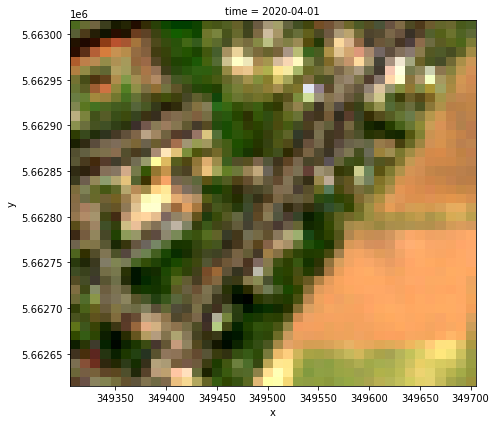

In [ ]:
%matplotlib inline
data.plot.imshow(row="time", rgb="band", robust=True, size=6);

In [64]:
nir, red = aoi.sel(band="B08"), aoi.sel(band="B04")
ndvi = (nir - red) / (nir + red)
ndvi = ndvi.persist()

KeyError: "not all values found in index 'band'. Try setting the `method` keyword argument (example: method='nearest')."